In [1]:
import numpy as np
import torch
base = "/content/drive/MyDrive/data_soli_dictionaries/"
from google.colab import drive
drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(device))

Mounted at /content/drive
Using cpu


# Data Cleaning and Setup


In [2]:
from torch.utils.data import Dataset

class SoliData(Dataset):
  def __init__(self, train,X_train,y_train,X_test,y_test,X_val,y_val):
        if train=="Train":
            self.data= X_train               # in this just define dataset of train and test after split into self.data
            self.target = y_train
        elif train=="Test":
            self.data = X_test
            self.target = y_test  
        else:
            self.data = X_val
            self.target = y_val             

  def __getitem__(self, index):
        target = self.target[index]                                                     # gets data point sequentially
        x = self.data[index]
        return x, target

  def __len__(self):
        return len(self.data)    

# Model Architecture

### Channel Atention layer
taken from [FcaNet Implementation](https://github.com/cfzd/FcaNet/blob/aa5fb63505575bb4e4e094613565379c3f6ada33/model/layer.py) 

In [3]:
import math
import torch
import torch.nn as nn

def get_freq_indices(method):
    """
    Returns: 2 lists consisting of frequency indices kx,ky DCT basis function phi_kx,ky[nx][ny]=cos(pi.kx.nx/Nx)cos(pi.ky.ny/Ny)
    method: tells which type of frequency indices are required
    """
    assert method in ['top1','top2','top4','top8','top16','top32',
                      'bot1','bot2','bot4','bot8','bot16','bot32',
                      'low1','low2','low4','low8','low16','low32']
    num_freq = int(method[3:])
    if 'top' in method:
        all_top_indices_x = [0,0,6,0,0,1,1,4,5,1,3,0,0,0,3,2,4,6,3,5,5,2,6,5,5,3,3,4,2,2,6,1]
        all_top_indices_y = [0,1,0,5,2,0,2,0,0,6,0,4,6,3,5,2,6,3,3,3,5,1,1,2,4,2,1,1,3,0,5,3]
        mapper_x = all_top_indices_x[:num_freq]
        mapper_y = all_top_indices_y[:num_freq]
    elif 'low' in method:
        all_low_indices_x = [0,0,1,1,0,2,2,1,2,0,3,4,0,1,3,0,1,2,3,4,5,0,1,2,3,4,5,6,1,2,3,4]
        all_low_indices_y = [0,1,0,1,2,0,1,2,2,3,0,0,4,3,1,5,4,3,2,1,0,6,5,4,3,2,1,0,6,5,4,3]
        mapper_x = all_low_indices_x[:num_freq]
        mapper_y = all_low_indices_y[:num_freq]
    elif 'bot' in method:
        all_bot_indices_x = [6,1,3,3,2,4,1,2,4,4,5,1,4,6,2,5,6,1,6,2,2,4,3,3,5,5,6,2,5,5,3,6]
        all_bot_indices_y = [6,4,4,6,6,3,1,4,4,5,6,5,2,2,5,1,4,3,5,0,3,1,1,2,4,2,1,1,5,3,3,3]
        mapper_x = all_bot_indices_x[:num_freq]
        mapper_y = all_bot_indices_y[:num_freq]
    else:
        raise NotImplementedError
    return mapper_x, mapper_y

class MultiSpectralAttentionLayer(torch.nn.Module):
    def __init__(self, channel, dct_h, dct_w, reduction = 16, freq_sel_method = 'top16'):
        """
        Initializes attention layer which takes in input as  3-D input cube C*H*W and returns the same dimensions
        channel:number of channels in input
        dct_h:Ht of 2D-DCT basis to be used
        dct_w:Width of 2D-DCT basis to be used
        reduction:Tells number of blocks input is reduced to(muzt be equal to number of DCT basis used)
        freq_sel_method:Tells number of DCT Basis functions to be used 
        """
        super(MultiSpectralAttentionLayer, self).__init__()
        self.reduction = reduction
        self.dct_h = dct_h
        self.dct_w = dct_w

        mapper_x, mapper_y = get_freq_indices(freq_sel_method)
        self.num_split = len(mapper_x)
        mapper_x = [temp_x * (dct_h // 7) for temp_x in mapper_x] 
        mapper_y = [temp_y * (dct_w // 7) for temp_y in mapper_y]
        # make the frequencies in different sizes are identical to a 7x7 frequency space
        # eg, (2,2) in 14x14 is identical to (1,1) in 7x7

        self.dct_layer = MultiSpectralDCTLayer(dct_h, dct_w, mapper_x, mapper_y, channel)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        n,c,h,w = x.shape
        x_pooled = x
        if h != self.dct_h or w != self.dct_w:
            x_pooled = torch.nn.functional.adaptive_avg_pool2d(x, (self.dct_h, self.dct_w))
            # If you have concerns about one-line-change, don't worry.   :)
            # In the ImageNet models, this line will never be triggered. 
            # This is for compatibility in instance segmentation and object detection.
        y = self.dct_layer(x_pooled)

        y = self.fc(y).view(n, c, 1, 1)
        return x * y.expand_as(x)


class MultiSpectralDCTLayer(nn.Module):
    """
    Generate dct filters
    """
    def __init__(self, height, width, mapper_x, mapper_y, channel):
        super(MultiSpectralDCTLayer, self).__init__()
        
        assert len(mapper_x) == len(mapper_y)
        assert channel % len(mapper_x) == 0

        self.num_freq = len(mapper_x)

        # fixed DCT init
        self.register_buffer('weight', self.get_dct_filter(height, width, mapper_x, mapper_y, channel))
        
        # fixed random init
        # self.register_buffer('weight', torch.rand(channel, height, width))

        # learnable DCT init
        # self.register_parameter('weight', self.get_dct_filter(height, width, mapper_x, mapper_y, channel))
        
        # learnable random init
        # self.register_parameter('weight', torch.rand(channel, height, width))

        # num_freq, h, w

    def forward(self, x):
        assert len(x.shape) == 4, 'x must been 4 dimensions, but got ' + str(len(x.shape))
        # n, c, h, w = x.shape

        x = x * self.weight #elt wise 

        result = torch.sum(x, dim=[2,3])
        return result

    def build_filter(self, pos, freq, POS):
        """
        Returns:cos(pi.freq.(n+1/2)/N)/sqrt(N)
        pos:n
        freq:k freq index
        POS:total Length
        """
        result = math.cos(math.pi * freq * (pos + 0.5) / POS) / math.sqrt(POS) 
        if freq == 0:
            return result
        else:
            return result * math.sqrt(2)
    
    def get_dct_filter(self, tile_size_x, tile_size_y, mapper_x, mapper_y, channel):
        dct_filter = torch.zeros(channel, tile_size_x, tile_size_y)

        c_part = channel // len(mapper_x)

        for i, (u_x, v_y) in enumerate(zip(mapper_x, mapper_y)):
            for t_x in range(tile_size_x):
                for t_y in range(tile_size_y):
                    dct_filter[i * c_part: (i+1)*c_part, t_x, t_y] = self.build_filter(t_x, u_x, tile_size_x) * self.build_filter(t_y, v_y, tile_size_y)
                        
        return dct_filter

## Modified Alex Net

In [4]:
import pickle
from random import sample
def get_data(train,number_of_frames):
  """
  Returns: training/testing data as a tuple of (X,y) where X is a list of gestures where each gesture is represented by 2-D vector (range evolution) telling position of objects i.e RP(1-d vector) vs time  and y is list of corresponding one hot encoded class labels
  each sample is (64,num_frames)
  train: boolean (true gives training data, false gives testing data)
  number_of_frames: int (decides time or number of RP to be used for representing each gesture)
  
  """
  if train:
    with open(base+'train.pickle', 'rb') as f:
        data = pickle.load(f)
  else:
    with open(base+'test.pickle', 'rb') as f:
      data = pickle.load(f)

  X = []
  y = []
  keys = np.arange(11)
  for key in keys:
    gesture_data = data[key]
    for i in range(len(gesture_data)):
      datapt_arr = gesture_data[i]
      datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
      datapt1 = np.sum(datapt,axis=2)
      datapt2 = np.sum(datapt,axis=1)
      datapt = np.hstack((datapt1,datapt2))
      datapt = datapt.T
      num_frames = np.shape(datapt)[1]

      if num_frames < number_of_frames:
          size = number_of_frames - num_frames
          use = np.zeros((64,size))
          datapt = np.hstack((datapt,use))      ## subsampling and extension so that finally all sequences are of length 40

      if num_frames > number_of_frames:
          datapt = datapt.T
          datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:]
          datapt = datapt.T
      
      minimum = datapt.min()
      maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
      datapt = (datapt-minimum)/((maximum-minimum))  

      X.append(datapt)
      y_temp = np.zeros(11)
      y_temp[key]=1
      y.append(y_temp)
  return X,y


In [5]:
import numpy as np
import torch
torch.manual_seed(0)
np.random.seed(0)
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class nnet(nn.Module):
  """
  This is the overall class implementing the CNN architecture
  """

  def __init__(self,inp_channels,num_filters,bw,neurons_2nd_last_lyr,neurons_last_lyr,relu=True):
    """
    inp_channels: Number of channels in your image for eg RGB has 3, Black and White has 1
    Num_Filters: How many filters should be used in the first convolutional layer
    bw: is the image black and white? [Boolean]
    neurons_2nd_last_lyr:number of neurons in second last layer
    neurons_last_lyr:number of neurons in last layer
    relu:if Relu activation has been used or not
    """

    super(nnet, self).__init__()
    self.inp_channels = inp_channels
    self.num_filters=num_filters
    self.bw = bw
    self.neurons1 = neurons_2nd_last_lyr
    self.neurons2 = neurons_last_lyr
    self.relu = relu

    self.conv1 = nn.Conv2d(self.inp_channels,num_filters,11,stride=1,padding=5) #doesn't change img dim only adds channels=num_filters
    self.pool1 = nn.MaxPool2d(3,stride=2) ## image dimensions halved
    self.conv2 = nn.Conv2d(self.num_filters,self.num_filters*2,5,stride=1,padding=2)
    self.pool2 = nn.MaxPool2d(2,stride=2) ## image dimensions halved
    self.conv3 = nn.Conv2d(self.num_filters*2,self.num_filters*2,3,stride=1,padding=1)
    self.conv4 = nn.Conv2d(self.num_filters*2,self.num_filters*2,3,stride=1,padding=1)
    self.conv5 = nn.Conv2d(self.num_filters*2,self.num_filters*2,3,stride=1,padding=1)
    self.pool3 = nn.MaxPool2d(2,stride=2) ## image dimensions halved
    
    ## Non Linearities are added using nn.Functional
    
    self.fc1 = nn.Linear(448,self.neurons1)   ## base this on input image dimension
    self.fc2 = nn.Linear(self.neurons1,self.neurons2)
    self.fc3 = nn.Linear(self.neurons2,11) 
    

  def forward(self,X):
    """
    Forward Loop of CNN.
    X is the input with dimension as: batch_size x input_channels x height x width
    """
    if self.bw:
      X = torch.unsqueeze(X,1)   ## in case your input image is 2D use this line to convert your 2D image into 3 Dimensional form [1 x height x width]
    
    if self.relu:
      X = F.relu(self.conv1(X))   # B_sizex8x64x40
      X = self.pool1(X)  # B_sizex8x31x19
      X = F.relu(self.conv2(X))  # B_sizex16x31x19
      X = self.pool2(X) # B_sizex16x15x9
      X = F.relu(self.conv3(X)) #B_sizex16x15x9
      X = F.relu(self.conv4(X)) #B_sizex16x15x9
      X = F.relu(self.conv5(X)) #B_sizex16x15x9
      X = self.pool3(X) # B_sizex16x7x4
      X = X.view(-1,448)  # B_sizex448
      X = F.relu(self.fc1(X))
      X = F.relu(self.fc2(X))
      X = torch.sigmoid(self.fc3(X))
    
    # else:
    #   X = torch.sigmoid(self.conv1(X))   # 6x32x40
    #   X = self.pool1(X)  ## 6x16x20
    #   X = torch.sigmoid(self.conv2(X))  ## 12x12x16
    #   X = self.pool2(X) ## 12x6x8

    #   X = X.view(-1,1344)  # Flatten the input before inputting into FC layers  576
    #   X = torch.sigmoid(self.fc1(X))
    #   X = torch.sigmoid(self.fc2(X))
    #   X = torch.sigmoid(self.fc3(X))


    return X 

In [7]:
from torchsummary import summary
model = nnet(1,8,True,320,160,True)
model.to(device)
summary(model,input_size=(64,40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 40]             976
         MaxPool2d-2            [-1, 8, 31, 19]               0
            Conv2d-3           [-1, 16, 31, 19]           3,216
         MaxPool2d-4            [-1, 16, 15, 9]               0
            Conv2d-5            [-1, 16, 15, 9]           2,320
            Conv2d-6            [-1, 16, 15, 9]           2,320
            Conv2d-7            [-1, 16, 15, 9]           2,320
         MaxPool2d-8             [-1, 16, 7, 4]               0
            Linear-9                  [-1, 320]         143,680
           Linear-10                  [-1, 160]          51,360
           Linear-11                   [-1, 11]           1,771
Total params: 207,963
Trainable params: 207,963
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

## FCA based Modified Alex  Net

In [8]:
class fcaNet(nn.Module):
  """
  This is the overall class implementing the CNN architecture
  """

  def __init__(self,inp_channels,num_filters,bw,neurons_2nd_last_lyr,neurons_last_lyr,relu=True):
    """
    inp_channels: Number of channels in your image for eg RGB has 3, Black and White has 1
    Num_Filters: How many filters should be used in the first convolutional layer
    bw: is the image black and white? [Boolean]
    neurons_2nd_last_lyr:number of neurons in second last layer
    neurons_last_lyr:number of neurons in last layer
    relu:if Relu activation has been used or not
    """

    super().__init__()
    self.inp_channels = inp_channels
    self.num_filters=num_filters
    self.bw = bw
    self.neurons1 = neurons_2nd_last_lyr
    self.neurons2 = neurons_last_lyr
    self.relu = relu

    self.conv1 = nn.Conv2d(self.inp_channels,num_filters,11,stride=1,padding=5) #doesn't change img dim only adds channels=num_filters
    self.pool1 = nn.MaxPool2d(3,stride=2) ## image dimensions halved
    self.conv2 = nn.Conv2d(self.num_filters,self.num_filters*2,5,stride=1,padding=2)
    self.pool2 = nn.MaxPool2d(2,stride=2) ## image dimensions halved
    self.conv3 = nn.Conv2d(self.num_filters*2,self.num_filters*2,3,stride=1,padding=1)
    self.fca   =  MultiSpectralAttentionLayer(self.num_filters*2,15,9)
    self.conv4 = nn.Conv2d(self.num_filters*2,self.num_filters*2,3,stride=1,padding=1)
    self.conv5 = nn.Conv2d(self.num_filters*2,self.num_filters*2,3,stride=1,padding=1)
    self.pool3 = nn.MaxPool2d(2,stride=2) ## image dimensions halved
    
    ## Non Linearities are added using nn.Functional
    
    self.fc1 = nn.Linear(448,self.neurons1)   ## base this on input image dimension
    self.fc2 = nn.Linear(self.neurons1,self.neurons2)
    self.fc3 = nn.Linear(self.neurons2,11) 
    

  def forward(self,X):
    """
    Forward Loop of CNN.
    X is the input with dimension as: batch_size x input_channels x height x width
    """
    if self.bw:
      X = torch.unsqueeze(X,1)   ## in case your input image is 2D use this line to convert your 2D image into 3 Dimensional form [1 x height x width]
    
    if self.relu:
      X = F.relu(self.conv1(X))   # B_sizex8x64x40
      X = self.pool1(X)  # B_sizex8x31x19
      X = F.relu(self.conv2(X))  # B_sizex16x31x19
      X = self.pool2(X) # B_sizex16x15x9
      X = F.relu(self.conv3(X)) #B_sizex16x15x9
      X = self.fca(X)
      X = F.relu(self.conv4(X)) #B_sizex16x15x9
      X = F.relu(self.conv5(X)) #B_sizex16x15x9
      X = self.pool3(X) # B_sizex16x7x4
      X = X.view(-1,448)  # B_sizex448
      X = F.relu(self.fc1(X))
      X = F.relu(self.fc2(X))
      X = torch.sigmoid(self.fc3(X))
    
    # else:
    #   X = torch.sigmoid(self.conv1(X))   # 6x32x40
    #   X = self.pool1(X)  ## 6x16x20
    #   X = torch.sigmoid(self.conv2(X))  ## 12x12x16
    #   X = self.pool2(X) ## 12x6x8

    #   X = X.view(-1,1344)  # Flatten the input before inputting into FC layers  576
    #   X = torch.sigmoid(self.fc1(X))
    #   X = torch.sigmoid(self.fc2(X))
    #   X = torch.sigmoid(self.fc3(X))


    return X 

In [9]:
from torchsummary import summary
model = fcaNet(1,8,True,320,160,True)
model.to(device)
summary(model,input_size=(64,40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 40]             976
         MaxPool2d-2            [-1, 8, 31, 19]               0
            Conv2d-3           [-1, 16, 31, 19]           3,216
         MaxPool2d-4            [-1, 16, 15, 9]               0
            Conv2d-5            [-1, 16, 15, 9]           2,320
MultiSpectralDCTLayer-6                   [-1, 16]           2,160
            Linear-7                    [-1, 1]              16
              ReLU-8                    [-1, 1]               0
            Linear-9                   [-1, 16]              16
          Sigmoid-10                   [-1, 16]               0
MultiSpectralAttentionLayer-11            [-1, 16, 15, 9]               0
           Conv2d-12            [-1, 16, 15, 9]           2,320
           Conv2d-13            [-1, 16, 15, 9]           2,320
        MaxPool2d-14      

## AlexNet

In [10]:
import pickle
import cv2
from random import sample
def get_data_custom_size(train,number_of_frames,remove_gestures=None,f_size=224):
  """
  Returns: training/testing data as a tuple of (X,y) where X is a list of gestures where each gesture is represented by 2-D vector (range evolution) telling position of objects i.e RP(1-d vector) vs time  and y is list of corresponding one hot encoded class labels
  Each sample in X is (64,num_frames,3)(H*W*C) and can be reshaped to a custom fr_size
  train: boolean (true gives training data, false gives testing data)
  number_of_frames: int (decides time or number of RP to be used for representing each gesture)
  remove_gestures:list of gestures to be removed from consideration eg [3,4]
  f_size:frame size for rescaling input

  """
  if train:
    with open(base+'train.pickle', 'rb') as f:
        data = pickle.load(f)
  else:
    with open(base+'test.pickle', 'rb') as f:
      data = pickle.load(f)

  X = []
  y = []
  if remove_gestures!=None:
    keys = np.zeros(11-len(remove_gestures),dtype=int)
    j=0
    for i in range(11):
      if i not in remove_gestures:#list of gestures to be removed [3,4]
        keys[j]=i
        j+=1
  else:
    keys = np.arange(11)

  keys = list(keys)    
  for key in keys:
    gesture_data = data[key]
    for i in range(len(gesture_data)):
      datapt_arr = gesture_data[i]
      datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
      datapt1 = np.sum(datapt,axis=2)
      datapt2 = np.sum(datapt,axis=1)
      datapt = np.hstack((datapt1,datapt2))
      datapt = datapt.T
      num_frames = np.shape(datapt)[1]

      if num_frames < number_of_frames:
          size = number_of_frames - num_frames
          use = np.zeros((64,size))
          datapt = np.hstack((datapt,use))      ## subsampling and extension so that finally all sequences are of fixed length 

      if num_frames > number_of_frames:
          datapt = datapt.T
          datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:]
          datapt = datapt.T

        
      datapt = cv2.resize(datapt,(f_size,f_size),interpolation=cv2.INTER_CUBIC)
      datapt = np.tile(datapt,(3,1,1))
     
      # datapt = datapt.T
      
      minimum = datapt.min()
      maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
      datapt = (datapt-minimum)/((maximum-minimum))

      X.append(datapt)
      y_temp = np.zeros(11-len(remove_gestures)) if remove_gestures else np.zeros(11)
      y_temp[keys.index(key)]=1
      y.append(y_temp)
  return X,y

In [11]:
import numpy as np
import torch
torch.manual_seed(0)
np.random.seed(0)
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# class alexNet(nn.Module):
#   """
#   This is the overall class implementing the CNN architecture
#   """

#   def __init__(self,inp_channels,num_filters,bw=True,neurons_2nd_last_lyr=4096,neurons_last_lyr=1000,relu=True):
#     """
#     inp_channels: Number of channels in your image for eg RGB has 3, Black and White has 1
#     Num_Filters: How many filters should be used in the first convolutional layer
#     bw: is the image black and white? [Boolean]
#     neurons_2nd_last_lyr:number of neurons in second last layer
#     neurons_last_lyr:number of neurons in last layer
#     relu:if Relu activation has been used or not
#     """

#     super().__init__()
#     self.inp_channels = inp_channels
#     self.num_filters=num_filters
#     self.bw = bw
#     self.neurons1 = neurons_2nd_last_lyr
#     self.neurons2 = neurons_last_lyr
#     self.relu = relu

#     self.conv1 = nn.Conv2d(self.inp_channels,96,11,stride=4) 
#     self.pool1 = nn.MaxPool2d(3,stride=2) ## image dimensions almost halved
#     self.conv2 = nn.Conv2d(96,256,5,stride=1,padding=2)
#     self.pool2 = nn.MaxPool2d(3,stride=2) ## image dimensions almost halved
#     self.conv3 = nn.Conv2d(256,384,3,stride=1,padding=1)
#     self.conv4 = nn.Conv2d(384,384,3,stride=1,padding=1)
#     self.conv5 = nn.Conv2d(384,256,3,stride=1,padding=1)
#     self.pool3 = nn.MaxPool2d(3,stride=2) ## image dimensions halved
    
#     ## Non Linearities are added using nn.Functional

#     self.fc1 = nn.Linear(12800,self.neurons1)   ## base this on input image dimension
#     self.fc2 = nn.Linear(self.neurons1,self.neurons1)
#     self.fc3 = nn.Linear(self.neurons1,self.neurons2)
#     self.fc4 = nn.Linear(self.neurons2,11) 
#     self.dropout = nn.Dropout(p=0.5)

#   def forward(self,X):
#     """
#     Forward Loop of CNN.
#     X is the input with dimension as: batch_size x input_channels x height x width
#     """
   
#     if self.relu:
#       X = F.relu(self.conv1(X))   # B_sizex54x54x96
#       X = self.pool1(X)  # B_sizex26x26x96
#       X = F.relu(self.conv2(X))  # B_sizex26x26x256
#       X = self.pool2(X) # B_sizex12x12x256
#       X = F.relu(self.conv3(X)) #B_sizex12x12x384
#       X = F.relu(self.conv4(X)) #B_sizex12x12x384
#       X = F.relu(self.conv5(X)) #B_sizex12x12x256
#       X = self.pool3(X) # B_sizex5x5x256
#       X = X.view(-1,12800)  # B_sizex448
#       X = self.dropout(F.relu(self.fc1(X)))
#       X = self.dropout(F.relu(self.fc2(X)))
#       X = (F.relu(self.fc3(X)))
      
#       X = torch.sigmoid(self.fc4(X))

In [12]:
class alexNet(nn.Module):
  def __init__(self, num_classes = 1000, dropout = 0.5) :
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

  def forward(self, x: torch.Tensor) :
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [13]:
from torchsummary import summary
model = alexNet(11)
model.to(device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

## FCA based AlexNet

In [14]:
class alexFCANet(nn.Module):
  def __init__(self, num_classes = 1000, dropout = 0.5) :
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),

            nn.ReLU(inplace=True),
            # MultiSpectralAttentionLayer(384,13,13),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            MultiSpectralAttentionLayer(256,13,13),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

  def forward(self, x: torch.Tensor) :
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
from torchsummary import summary
model = alexFCANet(11)
model.to(device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
MultiSpectralDCTLayer-11                  [-1, 256]          43,264
           Linear-12                   [-1, 16]           4,096
             ReLU-13                   [-1, 16]               0
           Linear-14               

## Training

In [16]:
import torch
import torch.nn as nn
import torch.optim as opti
import torch.nn.functional as func
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import statistics

def visualization(loss_arr,valloss,epo):
  x = np.linspace(1,epo,epo)
  plt.plot(x,loss_arr, label='Training Loss')
  plt.plot(x,valloss,label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.title('Training Curve')
  plt.legend()
  plt.show()

def train_single_epoch(lr,criterion,optimizer,device,nnet,trainloader,bsize,loss,valloader):
  nnet.train()                        ## a pytorch routine it is to turn ON some advanced layers which were turned OFF during testing  
  tloss =0
  for index,(x,y) in enumerate(trainloader):
    x= x.to(device).float()
    if loss == 'CrossEntropy':
      y = y.to(device).long()
    else:
      y = y.to(device).float()
    optimizer.zero_grad()          ## zeroing the gradients to nullify the effects of previous iterations
    pred_y = nnet(x)
    loss = criterion(pred_y,y)
    loss.backward()
    optimizer.step()
    tloss += loss.item() 
  tloss /= index

  nnet.eval()
  vloss =0
  

  with torch.no_grad():
    for index,(x,y) in enumerate(valloader):
      x= x.to(device).float()
      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()
      pred_y = nnet(x)
      loss = criterion(pred_y,y)
      vloss += loss.item()
  vloss /= index

    

  return tloss,vloss

def training(nnet,lr, epochs, batch_size,loss,mom,trainset,adaptive,sgd,valset):
  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)
  
  print('Data Setup Completed')

  print('Building model')
  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True

  if loss == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss()
  else:                                                                            ## choice of loss function
    criterion = nn.MSELoss()

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []
  valloss = []
  for epoch in range(epochs):
    l,vl= train_single_epoch(lr,criterion,optimizer,device,nnet,trainloader,batch_size,loss,valloader) 

    if sgd:
      if adaptive:
        if epoch == 0.7*epochs:
          lr = 0.1*lr
          optimizer = opti.SGD(nnet.parameters(),lr,mom) 

    
    trainloss.append(l)
    valloss.append(vl)
    # print("The loss was "+str(l))
  
  visualization(trainloss,valloss,epochs)

  print("Training Completed.")
  return nnet

def testing(testset,nnet,device,loss):
  if loss == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss()
  else:                                                                            ## choice of loss function
    criterion = nn.MSELoss()
  testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
  nnet.eval()                     ## a pytorch routine it is to turn OFF some advanced layers during testing   
  correct = 0
  total = 0
  with torch.no_grad():          ## turn OFF autograd
    for index,(x,y) in enumerate(testloader):
      total = total + 1
      x= x.to(device).float()

      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()

      pred_ysf = nnet(x)
      pred_y = torch.max(pred_ysf,1)[1][0]
      check_y = torch.max(y,1)[1][0]    ## to get the index of maximum value
      if (pred_y) == (check_y) :
        correct = correct +1
  return (correct/total)


In [ ]:
def testing_relu(testset,nnet,device,loss):
    
    testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    nnet.eval()                     ## a pytorch routine it is to turn OFF some advanced layers during testing   
    correct = 0
    total = 0
    with torch.no_grad():          ## turn OFF autograd
      for index,(x,y) in enumerate(testloader):
        total = total + 1
        x= x.to(device).float()

        if loss == 'CrossEntropy':
          y = y.to(device).long()
        else:
          y = y.to(device).float()

        pred_ysf = nnet(x)
        pred_cpu = pred_ysf.cpu().numpy()
        pred_array = np.asarray(pred_cpu)
        idx = (np.abs(pred_array-1.000000)).argmin()
        check_y = torch.max(y,1)[1][0]    ## to get the index of maximum value
        if idx == (check_y) :
          correct = correct +1
    return (correct/total)

In [ ]:
from sklearn.metrics import confusion_matrix
def testing_conf(testset,nnet,device,loss):
  predictions = []
  actual = []
  if loss == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss()
  else:                                                                            ## choice of loss function
    criterion = nn.MSELoss()
  testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
  nnet.eval()                     ## a pytorch routine it is to turn OFF some advanced layers during testing   
  correct = 0
  total = 0
  with torch.no_grad():          ## turn OFF autograd
    for index,(x,y) in enumerate(testloader):
      total = total + 1
      x= x.to(device).float()

      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()

      pred_ysf = nnet(x)
      pred_y = torch.max(pred_ysf,1)[1][0]
      check_y = torch.max(y,1)[1][0]    ## to get the index of maximum value
      predictions.append(pred_y.item())
      actual.append(check_y.item())
      if (pred_y) == (check_y) :
        correct = correct +1
  conf = confusion_matrix(actual,predictions)
  return (correct/total),conf

# Results

## Results for Modified AlexNet

In [17]:
X_train, y_train = get_data(True,40)
X_test_use, y_test_use = get_data(False,40)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import train_test_split
X_val =[]
y_val =[]
X_test=[]
y_test=[]
count = 124
for i in range(11):
  val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
  X_val.extend(val_X)
  X_test.extend(test_X)
  y_val.extend(val_y)
  y_test.extend(test_y)

Data Setup Started
Data Setup Completed
Building model


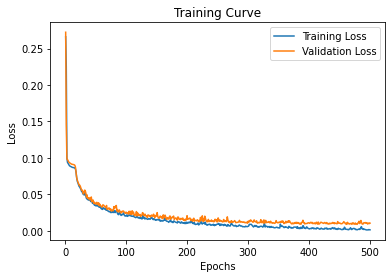

Training Completed.
0.9589442815249267
[[53  0  0  5  0  0  0  0  0  0  4]
 [ 0 62  0  0  0  0  0  0  0  0  0]
 [ 1  0 57  2  1  0  0  0  0  0  1]
 [ 5  0  0 56  1  0  0  0  0  0  0]
 [ 0  0  0  1 61  0  0  0  0  0  0]
 [ 0  0  0  0  0 61  0  0  0  1  0]
 [ 0  0  0  0  0  0 62  0  0  0  0]
 [ 0  0  0  0  0  0  0 62  0  0  0]
 [ 0  0  0  0  0  0  0  0 62  0  0]
 [ 0  1  0  0  1  1  0  0  3 56  0]
 [ 0  0  0  0  0  0  0  0  0  0 62]]


In [ ]:
model1 = nnet(1,8,True,112,56,True)   ## Does Very well!! [Some tuning needs to be done on it!]
model1 = training(model1,0.0003,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,False,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val))
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(accu)
print(conf)

## Results for AlexNet

In [ ]:
X_train, y_train = get_data_custom_size(True,40)
X_test_use, y_test_use = get_data_custom_size(False,40)

In [ ]:
print(X_train[0].shape,y_train[0].shape)

(3, 224, 224) (11,)


In [ ]:
from sklearn.model_selection import train_test_split
X_val =[]
y_val =[]
X_test=[]
y_test=[]
count = 124
for i in range(11):
  val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
  X_val.extend(val_X)
  X_test.extend(test_X)
  y_val.extend(val_y)
  y_test.extend(test_y)

Data Setup Started
Data Setup Completed
Building model


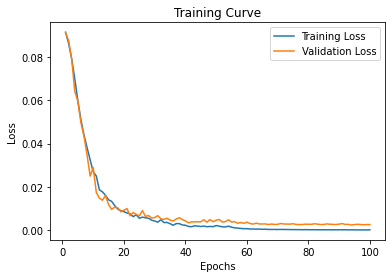

Training Completed.
[[118   0   0   3   0   0   0   0   0   0   3]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  1   0 119   1   2   0   0   0   0   1   0]
 [  5   0   1 115   1   1   0   0   0   0   1]
 [  0   0   0   0 124   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   0 124   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   2   0   0   1 121   0]
 [  1   0   0   0   0   0   0   0   0   0 123]]
0.9824046920821115


In [ ]:
model1 = alexNet(11)
training_data=SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val)
val_data=SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val)
test_data=SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val)
model1 = training(model1,0.0003,100,64,'MSE',0.9,training_data,True,False,val_data)
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
accu2, coonf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(conf+coonf2)                    ## 50-50 split accuracy
print(np.trace(conf+coonf2)/np.sum(conf+coonf2))


In [ ]:
torch.save(model1.module.state_dict(),"/content/drive/MyDrive/Saved_Models_BTP/alexNet_mp_model.pth")

## Results for FCA Mod AlexNet

In [ ]:
X_train, y_train = get_data(True,40)
X_test_use, y_test_use = get_data(False,40)

In [ ]:
from sklearn.model_selection import train_test_split
X_val =[]
y_val =[]
X_test=[]
y_test=[]
count = 124
for i in range(11):
  val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
  X_val.extend(val_X)
  X_test.extend(test_X)
  y_val.extend(val_y)
  y_test.extend(test_y)

Data Setup Started
Data Setup Completed
Building model
The loss was 0.25947501971608117
The loss was 0.23172666416281745
The loss was 0.10381946712732315
The loss was 0.09496518153519858
The loss was 0.09218448471455347
The loss was 0.08761097916534968
The loss was 0.08720546641520091
The loss was 0.08704572809594018
The loss was 0.08697877788827532
The loss was 0.0868539164463679
The loss was 0.08672812545583361
The loss was 0.08662494555825279
The loss was 0.08644274160975501
The loss was 0.08617702268418811
The loss was 0.08547995984554291
The loss was 0.08350621021929241
The loss was 0.07869114478429158
The loss was 0.07125843138921828
The loss was 0.06711517487253461
The loss was 0.06428736199935277
The loss was 0.06200718507170677
The loss was 0.05920081567906198
The loss was 0.05777843332006818
The loss was 0.055104546958491915
The loss was 0.053689555575450264
The loss was 0.050781444956858955
The loss was 0.05155414608972413
The loss was 0.04889012145854178
The loss was 0.0458

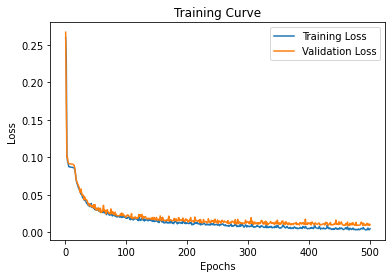

Training Completed.
0.9442815249266863
[[59  0  0  0  0  0  0  0  0  0  3]
 [ 0 62  0  0  0  0  0  0  0  0  0]
 [ 5  0 52  3  1  1  0  0  0  0  0]
 [10  0  1 51  0  0  0  0  0  0  0]
 [ 0  0  1  0 59  0  0  0  0  2  0]
 [ 0  0  0  0  0 60  0  0  0  2  0]
 [ 0  0  0  0  0  0 62  0  0  0  0]
 [ 0  0  1  0  0  0  0 61  0  0  0]
 [ 0  0  0  0  1  0  0  0 61  0  0]
 [ 0  0  1  1  0  1  0  0  0 59  0]
 [ 4  0  0  0  0  0  0  0  0  0 58]]


In [ ]:
model1 = fcaNet(1,8,True,112,56,True)   ## Does Very well!! [Some tuning needs to be done on it!]
model1 = training(model1,0.0003,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,False,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val))
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(accu)
print(conf)

## Results for FCA AlexNet

In [18]:
X_train, y_train = get_data_custom_size(True,40)
X_test_use, y_test_use = get_data_custom_size(False,40)

In [22]:
from timeit import default_timer as timer
num_iters = 50
ip=torch.from_numpy(X_train[0]).unsqueeze(0)
print(type(ip),ip.shape)
model1 = alexFCANet(11)
start = timer()
for i in range(num_iters):
  op = model(ip)
end = timer()
print(end-start)
print("Average time taken is: " + str((end-start)/num_iters))

<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
2.5856376899999987
Average time taken is: 0.051712753799999976


In [ ]:
from sklearn.model_selection import train_test_split
X_val =[]
y_val =[]
X_test=[]
y_test=[]
count = 124
for i in range(11):
  val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
  X_val.extend(val_X)
  X_test.extend(test_X)
  y_val.extend(val_y)
  y_test.extend(test_y)

Data Setup Started
Data Setup Completed
Building model


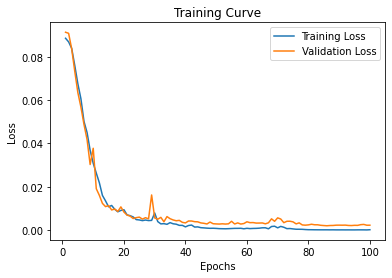

Training Completed.
[[118   0   0   4   0   0   0   0   0   0   2]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  0   0 120   2   2   0   0   0   0   0   0]
 [  5   0   1 116   0   1   0   0   0   0   1]
 [  0   0   1   0 123   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   0 124   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   1   0   0   0 123   0]
 [  1   0   0   0   0   0   0   0   0   0 123]]
0.9846041055718475


In [ ]:
model1 = alexFCANet(11) #Attention after 2nd Conv Layer
training_data=SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val)
val_data=SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val)
test_data=SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val)
model1 = training(model1,0.0003,100,64,'MSE',0.9,training_data,True,False,val_data)
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
accu2, coonf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(conf+coonf2)                    ## 50-50 split accuracy
print(np.trace(conf+coonf2)/np.sum(conf+coonf2))
